### Objective
To predict the concrete strength using the data available in file concrete_data.xls. Apply
feature engineering and model tuning to obtain 80% to 95% of R2score

### Attribute Information
Name -- Data Type -- Measurement -- Description
1. Cement (cement) -- quantitative -- kg in a m3 mixture -- Input Variable
2. Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture -- Input Variable
3. Fly Ash (ash) -- quantitative -- kg in a m3 mixture -- Input Variable
4. Water (water) -- quantitative -- kg in a m3 mixture -- Input Variable
5. Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture -- Input Variable
6. Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture -- Input Variable
7. Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture -- Input Variable
8. Age(age) -- quantitative -- Day (1~365) -- Input Variable
9. Concrete compressive strength(strength) -- quantitative -- MPa -- Output Variable

# Import all necessary modules and load the data

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder

### Import the dataframes that are needed

In [34]:
df = pd.read_csv('concrete.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,18.29


### Check for shape of data and data types!

In [35]:
df.shape

(1030, 9)

In [36]:
df.dtypes

cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object

#### Check for null values or missing values

In [37]:
df.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


### Print the descriptive statistics of each & every column using describe() function

In [39]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,"1,030.00",281.17,104.51,102.00,192.38,272.90,350.00,540.00
slag,"1,030.00",73.90,86.28,0.00,0.00,22.00,142.95,359.40
ash,"1,030.00",54.19,64.00,0.00,0.00,0.00,118.30,200.10
water,"1,030.00",181.57,21.35,121.80,164.90,185.00,192.00,247.00
superplastic,"1,030.00",6.20,5.97,0.00,0.00,6.40,10.20,32.20
coarseagg,"1,030.00",972.92,77.75,801.00,932.00,968.00,"1,029.40","1,145.00"
fineagg,"1,030.00",773.58,80.18,594.00,730.95,779.50,824.00,992.60
age,"1,030.00",45.66,63.17,1.00,7.00,28.00,56.00,365.00
strength,"1,030.00",35.82,16.71,2.33,23.71,34.45,46.14,82.60


#### Observations!

1. Dataset seems to be numerical no object or string type
2. No Null Values
3. Age data appears to have outliers because max value is very large.

# Exploratory data analysis

In [40]:
cor = df.corr()
cor

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.00,-0.28,-0.40,-0.08,0.09,-0.11,-0.22,0.08,0.50
slag,-0.28,1.00,-0.32,0.11,0.04,-0.28,-0.28,-0.04,0.13
ash,-0.40,-0.32,1.00,-0.26,0.38,-0.01,0.08,-0.15,-0.11
water,-0.08,0.11,-0.26,1.00,-0.66,-0.18,-0.45,0.28,-0.29
superplastic,0.09,0.04,0.38,-0.66,1.00,-0.27,0.22,-0.19,0.37
coarseagg,-0.11,-0.28,-0.01,-0.18,-0.27,1.00,-0.18,-0.00,-0.16
fineagg,-0.22,-0.28,0.08,-0.45,0.22,-0.18,1.00,-0.16,-0.17
age,0.08,-0.04,-0.15,0.28,-0.19,-0.00,-0.16,1.00,0.33
strength,0.50,0.13,-0.11,-0.29,0.37,-0.16,-0.17,0.33,1.00


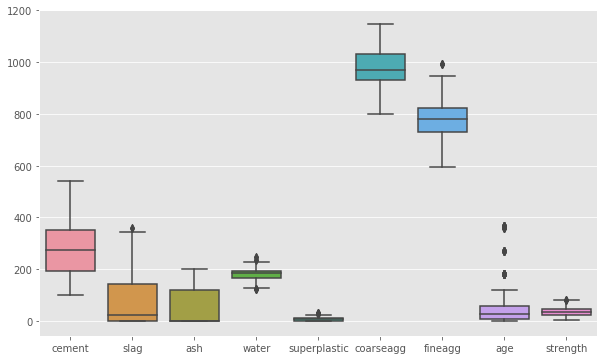

In [41]:
# BOX Plots

plt.subplots(figsize=(10, 6))
s = sns.boxplot(data=df)

### Observations
1. Age column appears to be having maximum number of outliers
2. Slag, Water, superplastic, fineagg features have some outliers
3. All features except age and strength have same units(kg in m3 mixture) but have different scales. Thus we might need to scale the data so as to avoid bias in algorithms

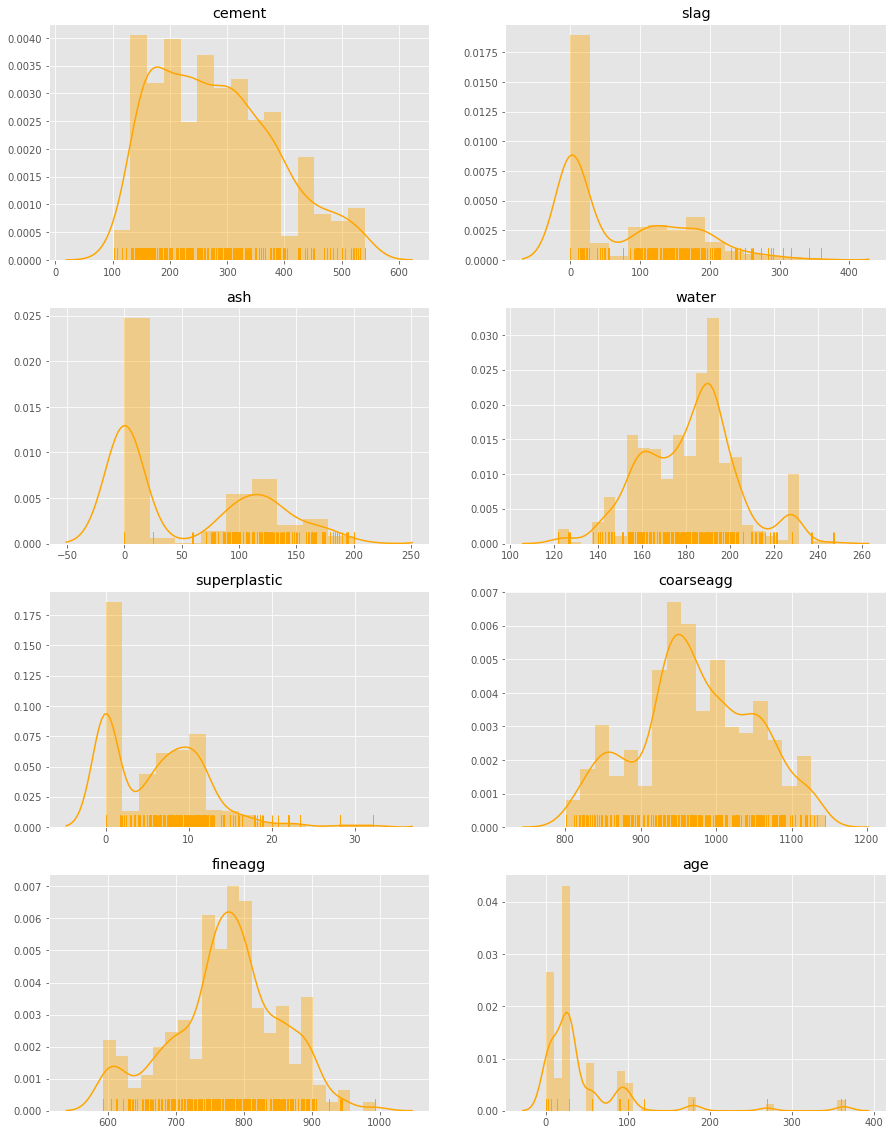

In [42]:
# Distplot for Depenent Variables
import itertools

cols = [i for i in df.columns if i != 'strength']
fig = plt.figure(figsize=(15, 20))
for i,j in itertools.zip_longest(cols, range(len(cols))):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(df[i],color='orange',rug=True)
    plt.title(i)
    plt.xlabel("")

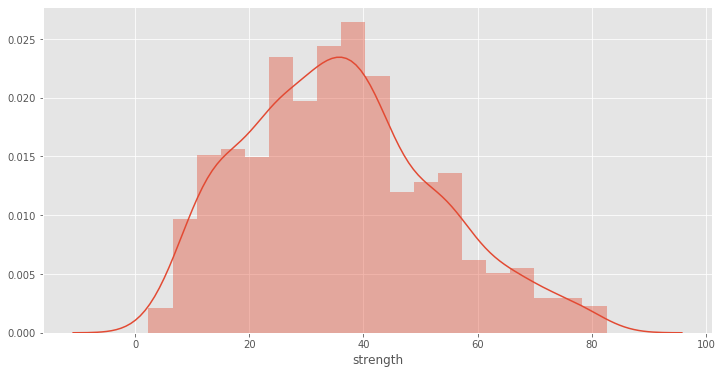

In [43]:
# Distplot for Independent Variable
fig = plt.figure(figsize=(12, 6))
sns.distplot(df.strength);

### Observations
1. Distribution of cement appears nearly normal
2. Slag and ash has 2 gaussians and is skewed
3. Water and Superplastic have near normal distributions
4. Age data has long tail which confirms the presence of outliers
5. Strength is normally distributed

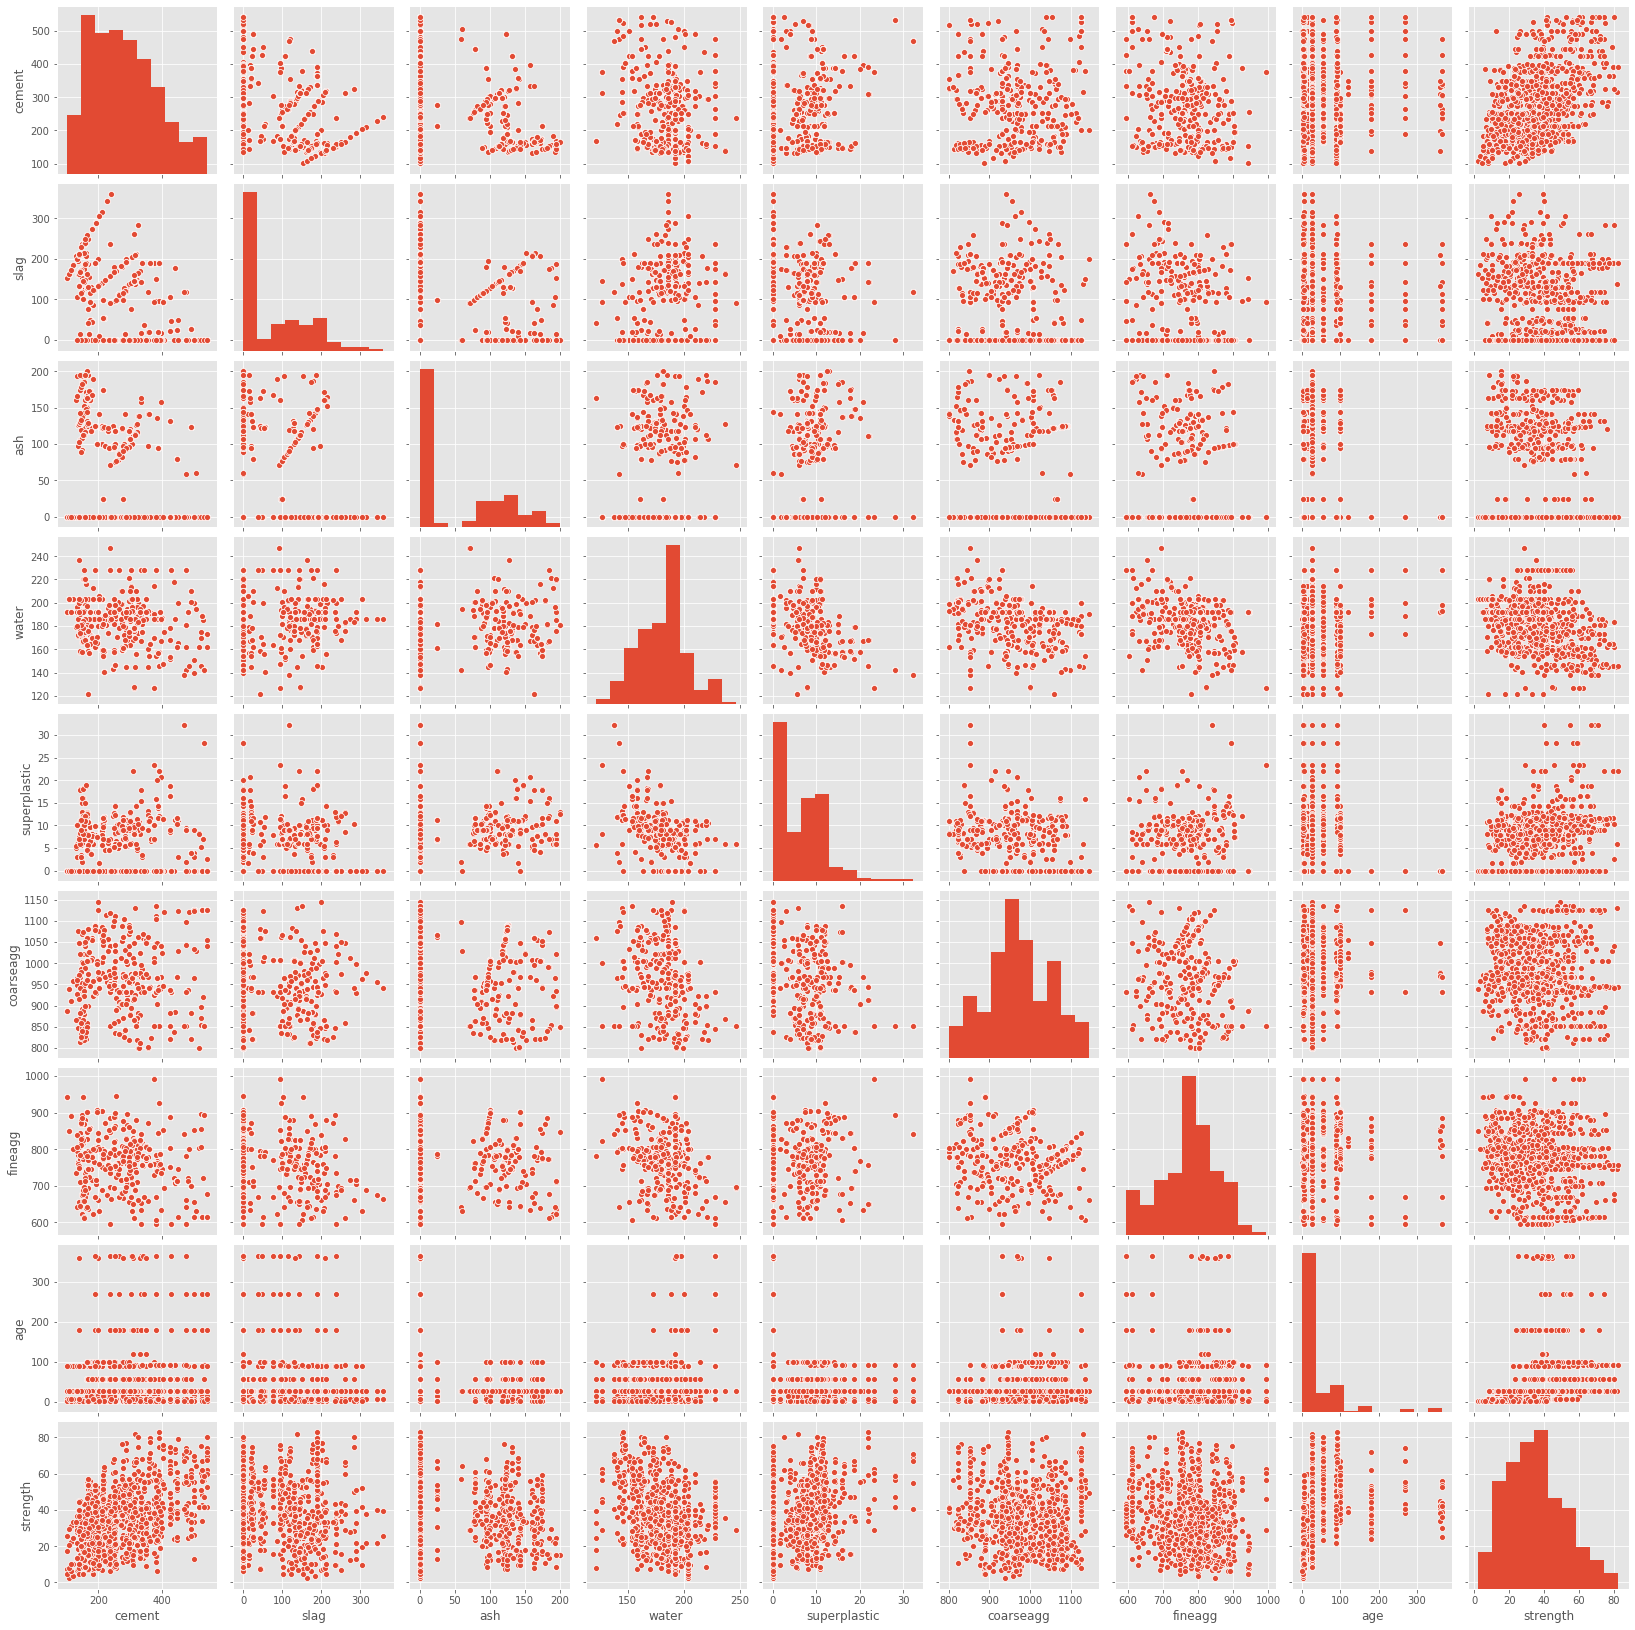

In [44]:
# Pair Plot

sns.pairplot(df)

### Observations
1. Cement has strong correlation with strength
2. Slag is a very weak predictor because the distribution is like a cloud
3. ash, coarseagg and fineagg are also weak predictors
4. Water appears to have a negative correlation with strength
5. Superplastic appears to have positive correlation with strength
6. age also has strong correlation with strength

### Use correlation method to observe the relationship between different variables and state your insights.

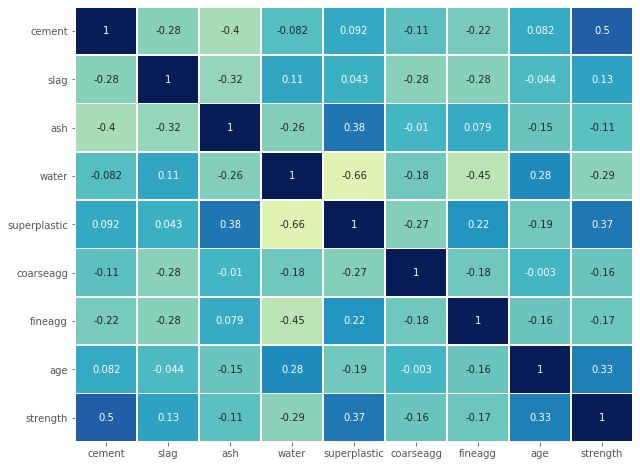

In [45]:
plt.figure(figsize=(10,8))

sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")

plt.show()

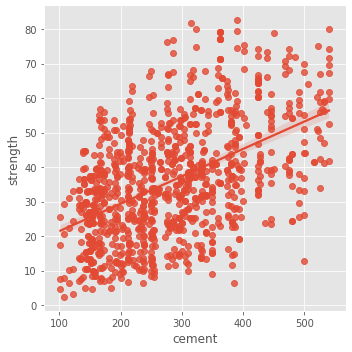

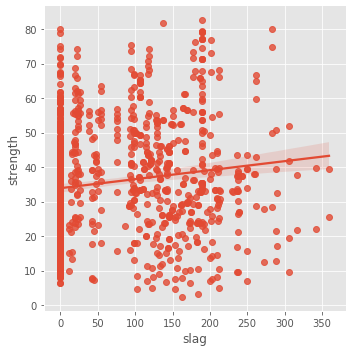

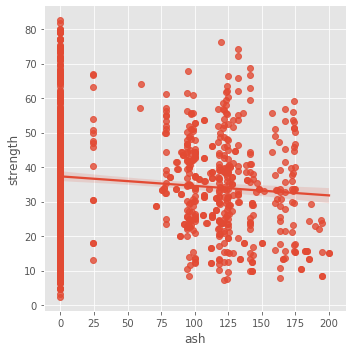

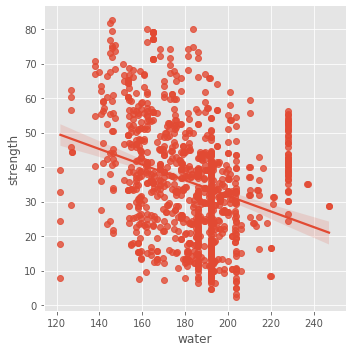

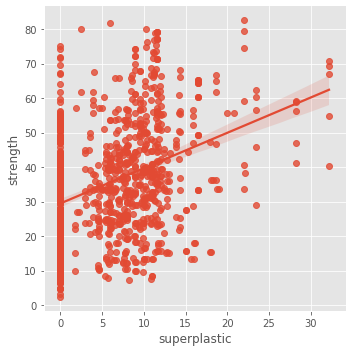

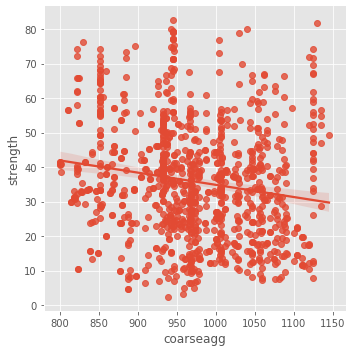

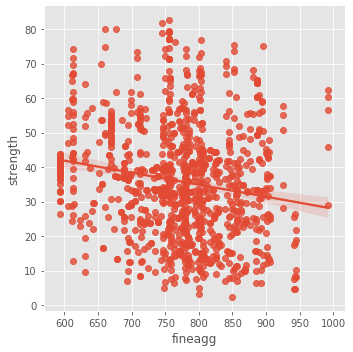

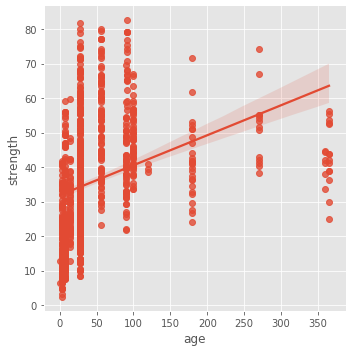

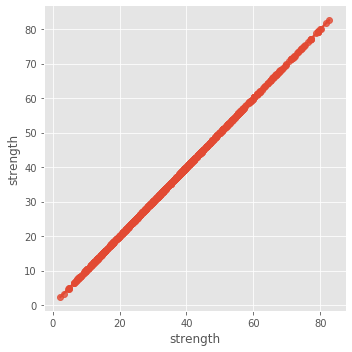

In [46]:
for col in df.columns:
  sns.lmplot(data=df, x=col, y='strength')

1. Water, superplastic, age and cement are the most important attributes for strength prediction
2. ash, coarseagg and fineagg are not strong predictors.
3. slag is mildly important predictor

3. Feature Engineering techniques (10 marks)
a. Identify opportunities (if any) to extract a new feature from existing features,
drop a feature (if required)
b. Get data model ready and do a train test split.
c. Decide on complexity of the model, should it be simple linear model in terms
of parameters or would a quadratic or higher degree.

#### Scaling

#MinMax Scaling - scales the data set such that all feature values are in the range [0, 1].
#StandardScaler - removes the mean and scales the data to unit variance


You can learn about other scalers here -
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [47]:
df_coded = df.copy()
df_coded.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [48]:
#Here we are going to use StandardScaler to scale our data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_scale = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength']

df_coded[cols_to_scale] = scaler.fit_transform(df_coded[cols_to_scale].to_numpy())
df_coded

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,-1.34,1.60,-0.85,1.03,-1.04,-0.01,-0.31,-0.28,-0.36
1,-1.07,-0.37,1.10,-1.09,0.77,1.39,0.28,-0.50,-0.74
2,-0.30,-0.86,0.65,0.27,-0.12,-0.21,1.09,-0.28,-0.40
3,-0.15,0.47,-0.85,2.18,-1.04,-0.53,-1.29,-0.28,0.60
4,-1.21,1.27,-0.85,0.55,0.48,0.96,-0.96,-0.28,-1.05
...,...,...,...,...,...,...,...,...,...
1025,-1.40,-0.86,1.75,-0.07,0.64,-0.15,0.39,-0.28,-1.35
1026,2.39,-0.86,-0.85,-1.86,3.68,-1.55,1.50,-0.68,0.33
1027,-0.05,0.49,0.56,-0.09,0.45,-1.32,-0.07,-0.28,0.51
1028,0.58,-0.42,-0.85,2.18,-1.04,-0.53,-1.29,3.55,1.15


### Create X and Y Variables

In [49]:
X = df.drop(columns= ['strength'])  # Seperating the target and the rest
y = df.strength

### Create train and test datasets

In [50]:
from sklearn.model_selection import train_test_split # Splitting the data for training and testing out model

#X_train, X_test, y_train, y_test = train_test_split(X,y.iloc[:,1], random_state = 1, stratify = y.iloc[:,1])


X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [51]:
X_train.dtypes

cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
dtype: object

### Print accuracy
- Print accuracy on test data using below models
- Logistic regression model trained using all the attributes
- Logistic regression model trained using only the feedback columns
- Decision tree model trained using all the attributes
- Random forest model trained using all the attributes

In [52]:
class Regressor(object):
    def __init__(self, name, model, scale=True, include_polynomial=False, degree=2):
        self.name = name
        self.model = model
        steps = []
        if scale:
            steps.append(('scaler', StandardScaler()))
        if include_polynomial:
            steps.append(('poly_features', PolynomialFeatures(degree=degree)))
        steps.append(('model', model))
        self.steps = steps

    def get_name(self):
        return self.name

    def get_model(self):
        return self.model
    
    def get(self):
        return Pipeline(steps=self.steps)

    def feature_imp(self):
        try:
            return self.model.feature_importances_
        except AttributeError:
            try:
                return self.model.coef_
            except AttributeError:
                return None

In [53]:
class ModelsBuilder(object):
    def __init__(self, regressors, data, target, test_size=0.3, seed=42):
        self.regressors = regressors
        self.split_data = train_test_split(data.drop(target, axis=1), data[target], test_size=test_size, random_state=seed)
        self.data = data
        self.target = target

    def build(self, k_fold_splits=10):
        results = pd.DataFrame(columns=['model', 'training_score', 'test_score', 'k_fold_mean', 'k_fold_std'])
        for regressor in self.regressors:
            regressor.get().fit(self.split_data[0], self.split_data[2])
            cross_vals = cross_val_score(regressor.get(), self.data.drop(self.target, axis=1), self.data[self.target], cv=KFold(n_splits=k_fold_splits))
            mean = round(cross_vals.mean(), 3)
            std = round(cross_vals.std(), 3)
            results = results.append({
                'model': regressor.get_name(),
                'training_score': round(regressor.get().score(self.split_data[0], self.split_data[2]), 3),
                'test_score': round(regressor.get().score(self.split_data[1], self.split_data[3]),3), 
                'k_fold_mean': mean, 
                'k_fold_std': std, 
                }, ignore_index=True)

        return results

In [54]:
regressors = [
    Regressor('Linear Regression', LinearRegression(), scale=True),  
    Regressor('Decision Tree', DecisionTreeRegressor(random_state=42, max_depth=4), scale=True),
    Regressor('Ada boosting', AdaBoostRegressor(random_state=42), scale=True),
    Regressor('Random forest', RandomForestRegressor(random_state=42, max_depth=4), scale=True),
    Regressor('Gradient boosting', GradientBoostingRegressor(random_state=42, max_depth=4), scale=True),
    Regressor('KNN', KNeighborsRegressor(n_neighbors=3), scale=True),
    Regressor('SVR', SVR(gamma='auto'), scale=True),
]

In [55]:
# Iteration 1 - Use all data
result = ModelsBuilder(regressors, df, 'strength').build()
tmp_best = result.sort_values(['k_fold_mean'], ascending=False).head(1)
tmp_best['model'] = 'Best Model = ' + tmp_best['model']
result = result.append(tmp_best, ignore_index=True)
result

,model,training_score,test_score,k_fold_mean,k_fold_std
0,Linear Regression,0.63,0.58,0.59,0.07
1,Decision Tree,0.73,0.67,0.67,0.05
2,Ada boosting,0.82,0.77,0.78,0.03
3,Random forest,0.83,0.80,0.76,0.03
4,Gradient boosting,0.97,0.90,0.92,0.02
5,KNN,0.86,0.73,0.72,0.04
6,SVR,0.67,0.62,0.65,0.04
7,Best Model = Gradient boosting,0.97,0.90,0.92,0.02


In [56]:
# Iteration 2 - Remove features based on k-means clustering
result_feature_engg = ModelsBuilder(regressors, df.drop(['ash', 'coarseagg', 'fineagg'], axis=1), 'strength').build()
tmp_best = result_feature_engg.sort_values(['k_fold_mean'], ascending=False).head(1)
tmp_best['model'] = 'Best Model = ' + tmp_best['model']
result_feature_engg = result_feature_engg.append(tmp_best, ignore_index=True)
result_feature_engg

,model,training_score,test_score,k_fold_mean,k_fold_std
0,Linear Regression,0.60,0.55,0.56,0.07
1,Decision Tree,0.73,0.67,0.68,0.05
2,Ada boosting,0.82,0.78,0.78,0.03
3,Random forest,0.83,0.80,0.76,0.03
4,Gradient boosting,0.97,0.90,0.92,0.02
5,KNN,0.89,0.75,0.79,0.03
6,SVR,0.71,0.67,0.70,0.03
7,Best Model = Gradient boosting,0.97,0.90,0.92,0.02


### Observations
1. Outliers treatment improves the overall performace on most of the models
2. Removing the features (ash, coarseagg and fineagg) does not affect the models.
3. Gradient boosting is clearly the best model. It provides better complexity with 95% confidence interval between 88% and 95%

# Hyper parameter tuning

Lets tune the hyper parameter for Gradient Boosting

* Steps:
1. Split the data into training and testing set (80-20)
2. Use the training data to perform cross validation hyper parameter tuning using Grid Search
3. Check the best performing model against the test set

In [57]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['ash', 'coarseagg', 'fineagg', 'strength'], axis=1), 
                                                   df['strength'], 
                                                   test_size = 0.2, 
                                                   random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((824, 5), (206, 5), (824,), (206,))

In [58]:
# Prepare parameter grid
param_grid = {
    'criterion': ['mse', 'mae', 'friedman_mse'], 
    'learning_rate': [0.05, 0.1, 0.15, 0.2], 
    'max_depth': [2, 3, 4, 5], 
    'max_features': ['sqrt', None], 
    'max_leaf_nodes': list(range(2, 10)),
    'n_estimators': list(range(50, 500, 50)),
    'subsample': [0.8, 0.9, 1.0]
}

In [59]:
# Perform hyper parameter tuning using GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_distributions=param_grid, 
                 return_train_score= True, n_jobs=-1, verbose=2, cv = 10, n_iter=500)
rs.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1162 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1686 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2213 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2850 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3881 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4650 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4989 out of 5000 | elapsed:  9.0min remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  9.0min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [60]:
mean = rs.best_score_
std = rs.cv_results_['mean_test_score'].std()

print(f"Mean training score: {rs.cv_results_['mean_train_score'].mean()}")
print(f"Mean validation score: {mean}")
print(f"Test score: {rs.score(X_test, y_test)}")

Mean training score: 0.9295581296139664
Mean validation score: 0.9315164484747183
Test score: 0.9233163222701359


# Conclusion:

- Given some data, we have seen how to perform EDA for that dataset
- The data is numeric, to understand better we draw visualization
- We used the same old bar-charts but the way we interpreted is unique to this problem
- Beyond EDA, we have seen how to preprocess data and train Supervised Models with it
- We finally put all the steps in one place and built a pipeline using the Sklearn's Pipeline function